In [98]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

In [99]:
numberNodes = 196591
numberEdges = 950327

with open('Gowalla_edges.txt', 'r') as f:
    strings = f.readlines()
edges = []
nodes = set()
similarity = []

for line in strings:
    node1, node2 = line.split()
    edges.append((int(node1), int(node2))) #список всех связей
    nodes.add((int(node1)))
    similarity.append(1) #cхожесть связей одинакова = 1
    
strings = None
    
for node in nodes:
    edges.append((node, node))  #диагональная связь 

In [106]:
def affinity_propagation(S, edges, iteration, diag_similarity):
   
    # формирование массива самоподобия и добавление шума
    S = np.array(S, dtype=np.int8)
    diag_similarity = np.repeat(diag_similarity, numberNodes)
    similarity = np.append(S, diag_similarity) 
    similarity = similarity + 1*(10**(-12))* np.random.sample(similarity.shape[0]) *(similarity.max() -similarity.min())
    
    # формирование массивов ответственности и доступности
    responsibility = np.repeat(0, similarity.shape[0])
    availability = np.repeat(0, similarity.shape[0])
    
    #кластеризация
    for i in range(iteration):
        responsibility = getResponsibility(similarity, availability, edges, responsibility)
        availability = getAvailability(availability, responsibility, edges)            
        print(i)
        
    # экземпляры класстера каждого пользователя
    result = getExemplars(availability, responsibility, edges)
    
    return result

In [107]:
def getResponsibility(S, A, edges, R):

    lam = 0.5
    Y = np.repeat(-np.inf, numberNodes)
    Y2 = np.repeat(-np.inf, numberNodes)
    I = np.repeat(np.inf, numberNodes)

    Rold = R.copy()
    S_A = S + A

    for ind, (node1, node2) in enumerate(edges):
        if Y[node1] < S_A[ind]:
            Y2[node1] = Y[node1]
            Y[node1] = S_A[ind]
            I[node1] = node2
        elif Y2[node1] < S_A[ind]:
            Y2[node1] = S_A[ind]

    R = S.copy()

    for ind, (node1, node2) in enumerate(edges):
        if I[node1] == node2:
            R[ind] -= Y2[node1]
        else:
            R[ind] -= Y[node1]

    R=(1-lam)*R+lam*Rold   # экпоненциальное сглаживание

    return R        

In [108]:
def getAvailability(A, R, edges):
    
    lam = 0.5
    Rold = R.copy()
    Aold = A.copy()
    i = 0
    
    while i < numberEdges * 2:
        if Rold[i] < 0:
            Rold[i] = 0
        i += 1

    Rp = np.repeat(0, numberNodes)
    
    for ind, (node1, node2) in enumerate(edges):
        Rp[node2] += Rold[ind]

    for ind, (node1, node2) in enumerate(edges):
        A[ind] = Rp[node2] - Rold[ind]
    
    i = 0
    while i < numberEdges * 2:
        A[i] = np.min([0, A[i]])
        i += 1
    
    A=(1-lam)*A+lam*Aold   #  экпоненциальным сглаживанием.
    
    return A

In [109]:
def getExemplars(A, R, edges):
    
    temp = np.repeat(-np.inf, numberNodes)
    exemplars = dict()
    
    E = A + R
    
    for ind, (node1, node2) in enumerate(edges):
        if E[ind] > temp[node1]:
            temp[node1] = E[ind]
            exemplars[node1] = node2
            
    for key in exemplars.keys():
        value = exemplars[key]
        if exemplars[value] != value:
            value2 = exemplars[value]
            exemplars[key] = value2
    
    return exemplars 

In [110]:
#def affinity_propagation(S, edges, iteration, diag_similarity):

#кластеризация

exemplars = affinity_propagation(similarity, edges, 10, -1)

0
1
2
3
4
5
6
7
8
9


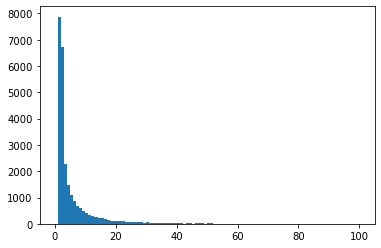

In [111]:
NumberClusters = set()
clusters = dict()

for exemplar in exemplars.values():
    if exemplar not in clusters:
        clusters[exemplar] = 1
    else:
        clusters[exemplar] += 1
    NumberClusters.add(i)
    
print(len(NumberClusters)) #количество кластеров        
plt.hist(clusters.values(), bins=100, range=(0, 100))
plt.show() # размеры кластеров

In [150]:
with open('Gowalla_totalCheckins.txt', 'r') as f:
    strings = f.readlines()

checkins = []
for string in strings:
    user = int(string.split()[0])
    location = int(string.split()[-1])
    checkins.append((user, location))
    
strings = None

shuffle(checkins) #смешивание

In [152]:
UniqueCheckSet = set()
for checkin in checkins:
    UniqueCheckSet.add(checkin[0])

numberUniqueCheck = len(UniqueCheckSet) #количество пользователей, оставлявших чекины
numberUniqueCheck

107092

In [153]:
# формирование тестовые (1/5) и тренеровочные данные
testData = set()
trainData = set()
for checkin in checkins:
    user = checkin[0]
    if len(testData) <= numberUniqueCheck/5:
        testData.add(user)
    elif user not in testData:
        trainData.add(user)

In [154]:
#количество чекинов по локации для каждого кластера
locationsInClusters = dict()
for (user, location) in checkins:
    if user in trainData:
        exemplar = exemplars[user]
        
        if exemplar not in locationsInClusters.keys():
            locationsInClusters[exemplar] = dict()
            
        else:
            if location not in locationsInClusters[exemplar].keys():
                locationsInClusters[exemplar][location] = 1
            else:
                locationsInClusters[exemplar][location] += 1
# топ 10          
topLocations = dict()
for exemplar in locationsInClusters:
    locationsInClusters[exemplar] = sorted(locationsInClusters[exemplar].items(), key=lambda item: item[1], reverse=True) 
for exemplar in locationsInClusters:
    topLocations[exemplar] = [location[0] for location in locationsInClusters[exemplar][:10]]

In [156]:
# процент угаданных пользователей 
quantity = 0
for (user, location) in checkins:
    if user in testData:
        exemplar = exemplars[user]
        if exemplar in topLocations and location in topLocations[exemplar]:
            quantity += 1
            
percent = quantity / len(testData) *10
percent

35.233204164526825